In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
## import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
#import pyLDAvis.gensim
#pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

# Variables


In [2]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [3]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [4]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

Dropping 0 entries of corpus, due to nan ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
14it [00:00, 135.93it/s]

Starting tokenization ...


1261it [00:04, 264.07it/s]


### tfidf

In [5]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

# find optimal k
TODO

# Clustering
Start with default params and tied for the covariance type because of the high CPU and RAM usage with full.
TODO: try different params

In [6]:
def fit_model(model, corpus):
    model.fit(corpus)

def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, vectorizer, corpus, labels, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(labels == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters
    
model = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model, tfidf_corpus.toarray())
labels = model.predict(tfidf_corpus.toarray())

clusters = print_and_get_clusters(model, vectorizer, corpus, labels)


Top terms per cluster:
Cluster 0:
('clustering', 'algorithm', 'density', 'cluster', 'based', 'data', 'hierarchical', 'spectral', 'graph', 'model')


Cluster 1:
('graph', 'model', 'graphical', 'algorithm', 'data', 'gaussian', 'problem', 'learning', 'network', 'method')


Cluster 2:
('model', 'inference', 'data', 'bayesian', 'variational', 'method', 'algorithm', 'network', 'process', 'learning')


Cluster 3:
('model', 'tensor', 'latent', 'data', 'factor', 'decomposition', 'variable', 'analysis', 'algorithm', 'method')


Cluster 4:
('learning', 'network', 'algorithm', 'data', 'model', 'machine', 'neural', 'method', 'time', 'problem')


Cluster 5:
('matrix', 'rank', 'low', 'method', 'algorithm', 'completion', 'bound', 'learning', 'norm', 'data')


Cluster 6:
('policy', 'learning', 'algorithm', 'method', 'iteration', 'model', 'gradient', 'action', 'space', 'based')


Cluster 7:
('causal', 'effect', 'variable', 'data', 'model', 'method', 'algorithm', 'learning', 'set', 'latent')


Cluster 8:

some words words are similar to kmeans. But there are a lot of words which are new. But the "buzzwords" are the same and the composition of words defining a cluster are very similar to kmeans.






# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


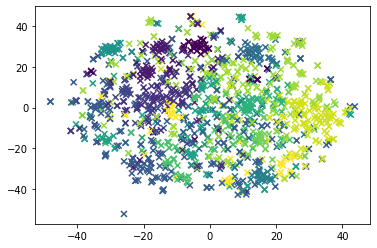

In [7]:
def plot(model, corpus, labels, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=labels, marker='x')
    plt.show()
plot(model, tfidf_corpus, labels)

no clusters visible

# Remove words which appear often in all clusters

In [8]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 13, 'learning': 12, 'data': 11, 'method': 11, 'model': 9, 'problem': 7, 'based': 3, 'network': 3, 'bound': 3, 'regression': 3, 'function': 3, 'graph': 2, 'gaussian': 2, 'process': 2, 'latent': 2, 'variable': 2, 'gradient': 2, 'space': 2, 'set': 2, 'risk': 2, 'convex': 2, 'optimal': 2, 'clustering': 1, 'density': 1, 'cluster': 1, 'hierarchical': 1, 'spectral': 1, 'graphical': 1, 'inference': 1, 'bayesian': 1, 'variational': 1, 'tensor': 1, 'factor': 1, 'decomposition': 1, 'analysis': 1, 'machine': 1, 'neural': 1, 'time': 1, 'matrix': 1, 'rank': 1, 'low': 1, 'completion': 1, 'norm': 1, 'policy': 1, 'iteration': 1, 'action': 1, 'causal': 1, 'effect': 1, 'feature': 1, 'selection': 1, 'forest': 1, 'gesture': 1, 'random': 1, 'kernel': 1, 'rate': 1, 'label': 1, 'class': 1, 'classification': 1, 'classifier': 1, 'loss': 1, 'multiclass': 1, 'regularization': 1, 'estimator': 1, 'high': 1, 'dimensional': 1, 'optimization': 1, 'stochastic':

most common words are similar to kmeans

In [9]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [10]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
28it [00:00, 274.51it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:07, 174.56it/s]


In [11]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [12]:
model_stopwords = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_stopwords, tfidf_corpus_stopwords.toarray())
labels_stopwords = model_stopwords.predict(tfidf_corpus_stopwords.toarray())

clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, corpus_stopwords, labels_stopwords)

Top terms per cluster:
Cluster 0:
('causal', 'effect', 'variable', 'set', 'latent', 'discovery', 'approach', 'inference', 'graph', 'cause')


Cluster 1:
('regression', 'estimator', 'high', 'problem', 'dimensional', 'approach', 'based', 'distribution', 'sample', 'matrix')


Cluster 2:
('graph', 'clustering', 'cluster', 'spectral', 'based', 'problem', 'density', 'random', 'function', 'set')


Cluster 3:
('network', 'neural', 'community', 'graphical', 'node', 'structure', 'layer', 'distribution', 'problem', 'set')


Cluster 4:
('kernel', 'regression', 'function', 'density', 'rate', 'based', 'space', 'estimator', 'mean', 'distribution')


Cluster 5:
('stochastic', 'optimization', 'problem', 'convex', 'gradient', 'function', 'convergence', 'non', 'rate', 'descent')


Cluster 6:
('matrix', 'rank', 'tensor', 'low', 'completion', 'bound', 'norm', 'problem', 'sampling', 'factorization')


Cluster 7:
('gaussian', 'process', 'inference', 'variational', 'gp', 'approximation', 'mixture', 'bayesian'

In [13]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 11, 'function': 7, 'set': 5, 'based': 5, 'regression': 4, 'approach': 3, 'distribution': 3, 'rate': 3, 'variable': 2, 'inference': 2, 'graph': 2, 'estimator': 2, 'sample': 2, 'matrix': 2, 'clustering': 2, 'density': 2, 'network': 2, 'space': 2, 'optimization': 2, 'gradient': 2, 'bound': 2, 'machine': 2, 'classification': 2, 'class': 2, 'framework': 2, 'causal': 1, 'effect': 1, 'latent': 1, 'discovery': 1, 'cause': 1, 'high': 1, 'dimensional': 1, 'cluster': 1, 'spectral': 1, 'random': 1, 'neural': 1, 'community': 1, 'graphical': 1, 'node': 1, 'structure': 1, 'layer': 1, 'kernel': 1, 'mean': 1, 'stochastic': 1, 'convex': 1, 'convergence': 1, 'non': 1, 'descent': 1, 'rank': 1, 'tensor': 1, 'low': 1, 'completion': 1, 'norm': 1, 'sampling': 1, 'factorization': 1, 'gaussian': 1, 'process': 1, 'variational': 1, 'gp': 1, 'approximation': 1, 'mixture': 1, 'bayesian': 1, 'time': 1, 'source': 1, 'python': 1, 'training': 1, 'loss': 1, 'risk'

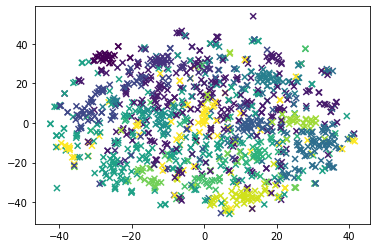

In [14]:
plot(model_stopwords, tfidf_corpus_stopwords, labels_stopwords)

Cluster looks a little bit better than before? But still not good. 

# LSA
- With LSA the calculation time is much less.
- TODO: find optimal n_components

In [15]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

use n_components=10 because it was used with kmeans. TODO: test with other vals for n_components.

In [16]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_lsa, X)
labels_lsa = model_lsa.predict(X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, corpus, labels_lsa, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('learning', 'bound', 'loss', 'algorithm', 'class', 'rate', 'label', 'sample', 'complexity', 'regret')


Cluster 1:
('model', 'data', 'inference', 'gaussian', 'method', 'process', 'bayesian', 'variational', 'latent', 'approach')


Cluster 2:
('algorithm', 'method', 'optimization', 'problem', 'stochastic', 'gradient', 'function', 'convex', 'convergence', 'non')


Cluster 3:
('clustering', 'algorithm', 'density', 'cluster', 'data', 'based', 'estimation', 'spectral', 'number', 'hierarchical')


Cluster 4:
('model', 'learning', 'data', 'method', 'feature', 'time', 'system', 'task', 'representation', 'training')


Cluster 5:
('learning', 'regression', 'kernel', 'function', 'data', 'algorithm', 'distributed', 'rate', 'problem', 'space')


Cluster 6:
('causal', 'variable', 'effect', 'data', 'model', 'algorithm', 'method', 'learning', 'set', 'latent')


Cluster 7:
('policy', 'learning', 'algorithm', 'method', 'problem', 'model', 'function', 'reinforcement', 'a

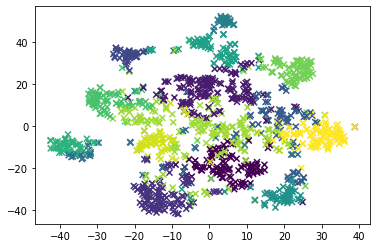

In [17]:
plot(model_lsa, X, labels_lsa, n_components=n_components)

In [18]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
model_lsa_stopwords = GaussianMixture(n_components=num_topics, covariance_type="tied")
fit_model(model_lsa_stopwords, X)
labels_lsa_stopwords = model_lsa_stopwords.predict(X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_lsa_stopwords, vectorizer_stopwords, corpus_stopwords, labels_lsa_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('loss', 'bound', 'rate', 'sample', 'complexity', 'class', 'label', 'error', 'distribution', 'active')


Cluster 1:
('regression', 'estimator', 'high', 'lasso', 'dimensional', 'selection', 'distributed', 'estimation', 'linear', 'approach')


Cluster 2:
('network', 'neural', 'node', 'community', 'deep', 'layer', 'structure', 'set', 'prediction', 'time')


Cluster 3:
('clustering', 'density', 'cluster', 'based', 'hierarchical', 'spectral', 'estimation', 'number', 'problem', 'set')


Cluster 4:
('graph', 'graphical', 'problem', 'based', 'vertex', 'random', 'function', 'network', 'distribution', 'result')


Cluster 5:
('matrix', 'rank', 'low', 'bound', 'tensor', 'completion', 'norm', 'problem', 'covariance', 'sparse')


Cluster 6:
('problem', 'result', 'subspace', 'approach', 'sample', 'based', 'sparse', 'linear', 'analysis', 'set')


Cluster 7:
('kernel', 'regression', 'function', 'based', 'rate', 'space', 'problem', 'mean', 'sample', 'estimator')


Clust

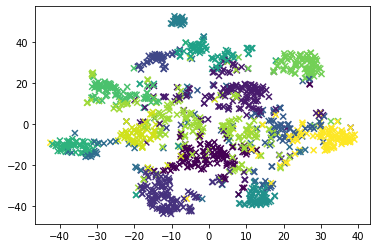

In [19]:
plot(model_lsa_stopwords, X, labels_lsa, n_components=n_components)

When using the tfidf corpus as input it doesn't look so nice clustered than before, but a litlle bit better than without lsa:

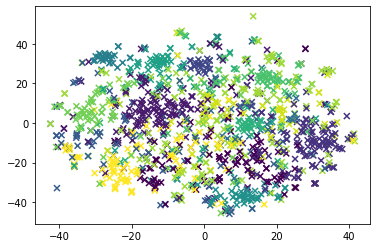

In [20]:
plot(model_lsa_stopwords, tfidf_corpus_stopwords.toarray(), labels_lsa, n_components=n_components)

# Metrics
Metrics provided from sklearn, that don't need true labels:

    metrics.silhouette_score
    metrics.calinski_harabasz_score
    metrics.davies_bouldin_score
    
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [21]:
def calc_scores(corpus, model, labels):
    return metrics.silhouette_score(corpus, labels, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), labels), metrics.davies_bouldin_score(corpus.toarray(), labels)
scores = []
score = list(calc_scores(tfidf_corpus, model, labels))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords, labels_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)
score = list(calc_scores(tfidf_corpus, model_lsa, labels_lsa))
score.insert(0, 'model_lsa')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_lsa_stopwords, labels_lsa_stopwords))
score.insert(0, 'model_lsa_stopwords')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                    model type  silhouette_score  calinski_harabasz_score  \
0                 normal model          0.011229                 4.739231   
1  model with custom stopwords          0.010517                 4.590532   
2                    model_lsa          0.011231                 4.692267   
3          model_lsa_stopwords          0.012277                 4.674865   

   davies_bouldin_score  
0              7.054003  
1              7.247063  
2              7.668880  
3              7.716621  


kmeans achieves better scores. But with LSA the scores are better than the score of kmeans with lsa.